In [1]:
import sys
import time
from typing import Dict

import torch
import numpy as np
import matplotlib.pyplot as plt
from epics import caget, caput, cainfo

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../NN_prior/")
from custom_mean import CustomMean
from dynamic_custom_mean import DynamicCustomMean
from metric_informed_custom_mean import MetricInformedCustomMean

## Create model

In [2]:
model_path = "lcls_cu_injector_nn_model/"

In [3]:
# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

In [4]:
# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

In [5]:
# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],  # pv_to_sim before sim_to_nn
    output_transformers=[output_sim_to_nn, output_pv_to_sim],  # sim_to_nn before pv_to_sim
)

In [6]:
# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=lume_model.features,
    output_order=lume_model.outputs[0:2],
)
print(lume_module.output_order)

['OTRS:IN20:571:XRMS', 'OTRS:IN20:571:YRMS']


In [7]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

## Test on example data

In [8]:
# load example data and calculate predictions
inputs_small = input_pv_to_sim.untransform(torch.load(model_path + "info/inputs_small.pt"))
outputs_small = output_pv_to_sim.untransform(torch.load(model_path + "info/outputs_small.pt"))
with torch.no_grad():
    predictions = lume_module(inputs_small)

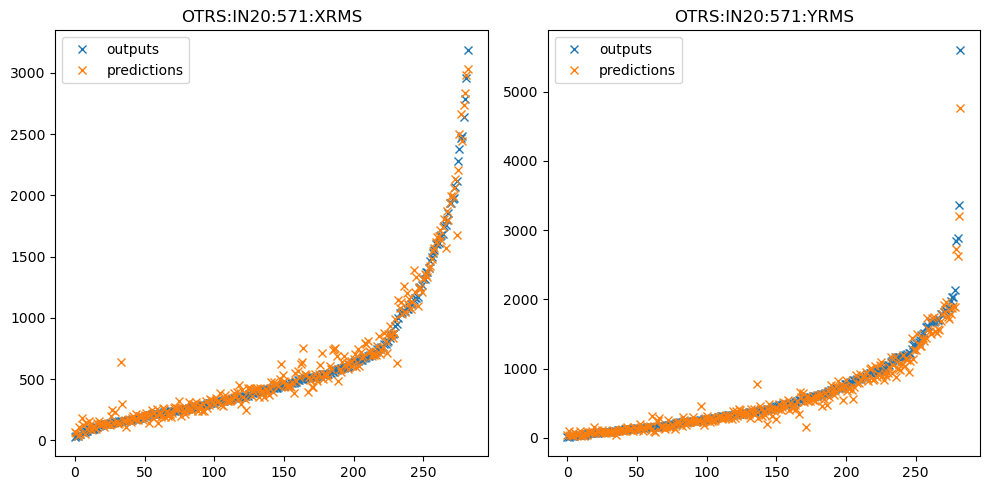

In [9]:
# plot example data and predictions
nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5))
for i, output_name in enumerate(lume_module.output_order):
    sort_idx = torch.argsort(outputs_small[:, i])
    x_axis = torch.arange(outputs_small.shape[0])
    ax[i].plot(x_axis, outputs_small[sort_idx, i], "C0x", label="outputs")
    ax[i].plot(x_axis, predictions[sort_idx, i], "C1x", label="predictions")
    ax[i].legend()
    ax[i].set_title(output_name)
fig.tight_layout()

## Build vocs-file

In [10]:
# inputs
vocs_variables, vocs_constants = {}, {}
for input_name, variable in lume_model.input_variables.items():
    if variable.value_range[0] == variable.value_range[1]:
        vocs_constants[input_name] = variable.value_range[0]
    elif input_name in ["Pulse_length", "CAMR:IN20:186:R_DIST", "ACCL:IN20:300:L0A_PDES", "ACCL:IN20:400:L0B_PDES"]:
        vocs_constants[input_name] = variable.default
    else:
        vocs_variables[input_name] = variable.value_range

# outputs
observables = lume_module.output_order
    
vocs = VOCS(
    variables=vocs_variables,
    constants=vocs_constants,
    objectives={"sigma_xy": "MINIMIZE"},
    observables=observables,
    constraints={},
)

In [11]:
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BACT: [0.3774080152672698, 0.4983800018349345]
  QUAD:IN20:121:BACT: [-0.02098429469554406, 0.020999198106589838]
  QUAD:IN20:122:BACT: [-0.020998830517503037, 0.020998929132148195]
  QUAD:IN20:361:BACT: [-4.318053641915576, -1.0800430432494976]
  QUAD:IN20:371:BACT: [1.0913525514575348, 4.30967984810423]
  QUAD:IN20:425:BACT: [-7.559759590824369, -1.080762695815712]
  QUAD:IN20:441:BACT: [-1.0782202690353522, 7.559878303179915]
  QUAD:IN20:511:BACT: [-1.0792451325247663, 7.5582919025608595]
  QUAD:IN20:525:BACT: [-7.557932980106783, -1.0800286565992732]
constraints: {}
objectives: {sigma_xy: MINIMIZE}
constants: {'CAMR:IN20:186:R_DIST': 423.867825, Pulse_length: 1.8550514181818183,
  'FBCK:BCI0:1:CHRG_S': 0.25, 'ACCL:IN20:300:L0A_ADES': 58.0, 'ACCL:IN20:300:L0A_PDES': -9.53597349,
  'ACCL:IN20:400:L0B_ADES': 70.0, 'ACCL:IN20:400:L0B_PDES': 9.85566222}
observables: ['OTRS:IN20:571:XRMS', 'OTRS:IN20:571:YRMS']



In [12]:
# with open("vocs.yaml", "w") as f:
#     f.write(vocs.as_yaml())
#     f.close()

## Define evaluate function

In [13]:
# r_dist = np.sqrt(data["CAMR:IN20:186:XRMS"].values ** 2 + data["CAMR:IN20:186:YRMS"].values ** 2)
def evaluate(input_dict: Dict) -> Dict:
    # set inputs
    for key, value in input_dict.items():
        if key == "CAMR:IN20:186:R_DIST":
            keys = ["CAMR:IN20:186:XRMS", "CAMR:IN20:186:YRMS"]
            value_i = np.sqrt(0.5 * value ** 2)
            for key_i in keys:
                print(f'setting {key_i} to {value_i}')
                caput(key_i, value_i)
        else:
            print(f'setting {key} to {value}')
            caput(key, value)
    
    # wait for inputs to settle
    time.sleep(5.0)

    # get output values
    output_dict = {}
    for output_name in vocs.observables:
        print(f'getting {output_name}')
        output_dict[output_name] = caget(output_name)

    # calculate objective
    sigma_x = torch.tensor(output_dict["OTRS:IN20:571:XRMS"])
    sigma_y = torch.tensor(output_dict["OTRS:IN20:571:YRMS"])
    sigma_xy = objective_model.function(sigma_x=sigma_x, sigma_y=sigma_y)
    output_dict[vocs.objective_names[0]] = sigma_xy.detach().item()

    return output_dict

## Define prior mean

In [14]:
# define custom mean
mean_class = CustomMean
mean_kwargs = {"model": objective_model}

## Create Xopt instance

In [15]:
# Xopt definition
model_constructor = StandardModelConstructor(
    mean_modules={vocs.objective_names[0]: mean_class(**mean_kwargs)},
    trainable_mean_keys=[vocs.objective_names[0]],
)
numerical_optimizer = LBFGSOptimizer(n_restarts=5, n_raw_samples=20)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

## Create initial samples

In [ ]:
# create initial samples
n_init = 3
X.random_evaluate(n_samples=n_init)

## Run optimization

In [ ]:
n_step = 50
for step in range(n_step):
    # define prior mean
    if issubclass(mean_class, DynamicCustomMean):
        mean_kwargs["step"] = step
    elif issubclass(mean_class, MetricInformedCustomMean):
        if step == 0:
            mean_kwargs["metrics"] = {"correlation": 1.0}
        else:
            x_samples = torch.tensor(X.data[vocs.variable_names].values, dtype=torch.double)
            y_samples = torch.tensor(X.data[vocs.objective_names].values, dtype=torch.double).squeeze()
            y_samples_prior = mean_kwargs["model"](x_samples).squeeze()
            correlation = calc_corr(y_samples, y_samples_prior)
            mean_kwargs["metrics"] = {"correlation": correlation}
    X.generator.model_constructor.mean_modules[vocs.objective_names[0]] = mean_class(**mean_kwargs)

    # optimization step
    t0 = time.time()
    X.step()
    print("Completed step {:d} ({:.2f} sec)".format(step, time.time() - t0))